In [13]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf

sys.path.insert(0, "..") 
from src.data import make_dataset
from src.features import build_features
from src.visualization import visualize

pd.set_option("display.precision", 5)
pd.set_option("display.max.columns", None)
pd.options.display.float_format = '{:6.5f}'.format



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Naive model

Het eerste model wat we willen proberen is de 'naive voorspelling'. Dit is een base line model ter beoordeling van de resultaten van de overige modellen.

In [5]:
# Shape of the Bond data is simple: Bond, rate_dt, price
df_price = make_dataset.read_pkl('price')

# Create a model that will predict 10 steps into the future, given as much data as available.


2022-01-05 20:38:48.173 | INFO     | src.data.make_dataset:read_pkl:364 - Load preprocessed price data


In [6]:
df_price['reference_identifier'].unique()

<StringArray>
['BE0000332412', 'NL0010721999', 'IE00B6X95T99', 'NL0010733424',
 'XS1062909384', 'DE0001102358', 'AT0000A185T1', 'FR0011962398',
 'FR0011883966', 'DE0001102366',
 ...
 'FR0011196856', 'DE0001135499', 'FR0011337880', 'BE0000325341',
 'BE0000328378', 'DE0001102309', 'NL0010418810', 'AT0000A105W3',
 'FR0011486067', 'NL0010514246']
Length: 215, dtype: string

2022-01-05 20:39:43.470 | INFO     | src.data.make_dataset:read_pkl:364 - Load preprocessed price data


Data 427
Training 298
Validation 86
Test 43


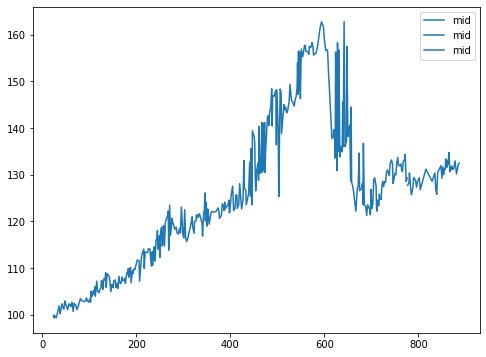

In [11]:
(df_train, df_val, df_test) = make_dataset.read_single_bond('NL0010721999')
visualize.lplot([df_train, df_val, df_test ])

In [14]:
from src.models import base_model
from src.models import window

w = window.WindowGenerator(24,24,1,df_train,df_val, df_test, ['mid'])

# For sampling business Days
#    from pandas.tseries.offsets import BDay
#    pd.date_range('2015-07-01', periods=5, freq=BDay())

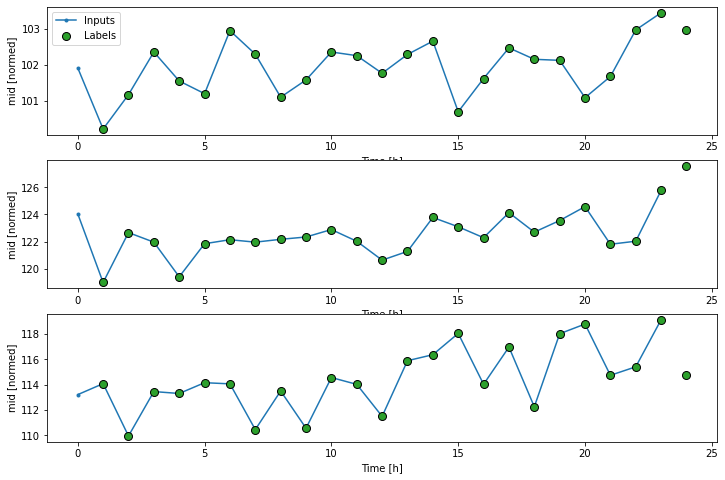

In [15]:
w.plot()

In [16]:
w.train.element_spec

(TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))

In [17]:
for example_inputs, example_labels in w.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 1)
Labels shape (batch, time, features): (32, 24, 1)


In [18]:
single_step_window = window.WindowGenerator(
    input_width=1, label_width=1, shift=1, df_train = df_train,df_val = df_val, df_test = df_test,
    label_columns=['mid'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['mid']

In [19]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [20]:
baseline = base_model.Baseline(label_index=w.column_indices['mid'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 4ms/step - loss: 84.3663 - mean_absolute_error: 5.3021


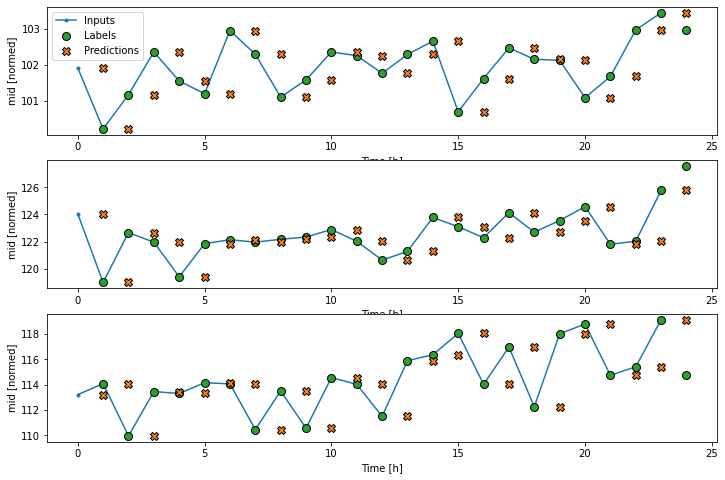

In [21]:
w.plot(baseline)

In [22]:
wide_window = window.WindowGenerator(
    input_width=24, label_width=24, shift=1, df_train = df_train, df_test = df_test, df_val = df_val,
    label_columns=['mid'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['mid']

In [29]:

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


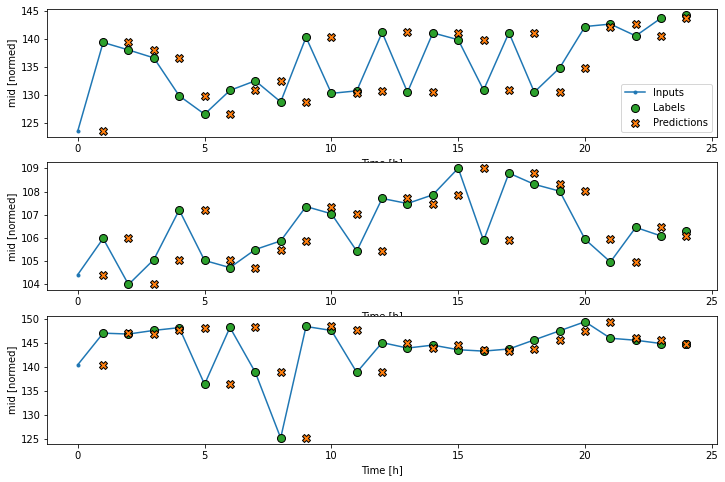

In [23]:
wide_window.plot(baseline)

In [24]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [26]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [27]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [30]:
history = compile_and_fit(linear, wide_window)

val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

Epoch 1/20
9/9 [==============================] - 1s 31ms/step - loss: 17.6141 - mean_absolute_error: 2.6846 - val_loss: 66.0977 - val_mean_absolute_error: 4.6967
Epoch 2/20
9/9 [==============================] - 0s 18ms/step - loss: 17.3574 - mean_absolute_error: 2.6196 - val_loss: 66.4128 - val_mean_absolute_error: 4.7081
Epoch 3/20
9/9 [==============================] - 0s 20ms/step - loss: 17.3213 - mean_absolute_error: 2.6182 - val_loss: 65.9498 - val_mean_absolute_error: 4.6911
Epoch 4/20
9/9 [==============================] - 0s 18ms/step - loss: 17.3110 - mean_absolute_error: 2.6215 - val_loss: 65.8949 - val_mean_absolute_error: 4.6903
Epoch 5/20
9/9 [==============================] - 0s 18ms/step - loss: 17.2985 - mean_absolute_error: 2.6181 - val_loss: 66.0961 - val_mean_absolute_error: 4.6967
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 66.0282 - mean_absolute_error: 4.6943


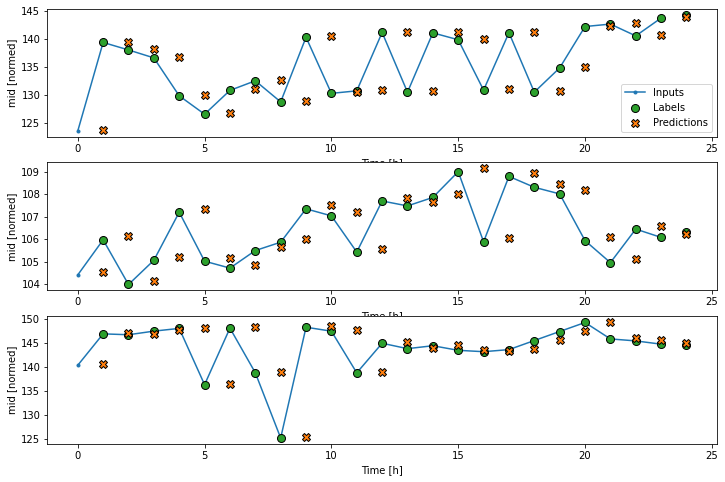

In [31]:
wide_window.plot(linear)

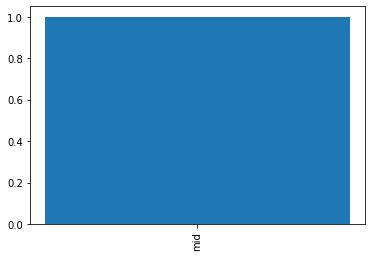

In [32]:
plt.bar(x = range(len(df_train.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(df_train.columns)))
_ = axis.set_xticklabels(df_train.columns, rotation=90)

In [43]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, wide_window)

val_performance['Dense'] = dense.evaluate(wide_window.val)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

Epoch 1/20
9/9 [==============================] - 1s 40ms/step - loss: 10509.3184 - mean_absolute_error: 101.0638 - val_loss: 7168.9688 - val_mean_absolute_error: 84.3869
Epoch 2/20
9/9 [==============================] - 0s 24ms/step - loss: 4534.9165 - mean_absolute_error: 65.9846 - val_loss: 2550.9697 - val_mean_absolute_error: 50.0230
Epoch 3/20
9/9 [==============================] - 0s 21ms/step - loss: 1303.5991 - mean_absolute_error: 34.7510 - val_loss: 417.4272 - val_mean_absolute_error: 19.0485
Epoch 4/20
9/9 [==============================] - 0s 19ms/step - loss: 121.6718 - mean_absolute_error: 8.8383 - val_loss: 85.8591 - val_mean_absolute_error: 6.6789
Epoch 5/20
9/9 [==============================] - 0s 17ms/step - loss: 87.1231 - mean_absolute_error: 8.2583 - val_loss: 208.7159 - val_mean_absolute_error: 12.7436
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 117.8861 - mean_absolute_error: 8.7561


In [44]:
CONV_WIDTH = 3
conv_window = window.WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    df_train = df_train,
    df_val = df_val,
    df_test = df_test,
    label_columns=['mid'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['mid']

Text(0.5, 1.0, 'Given 3 days of inputs, predict 1 day into the future.')

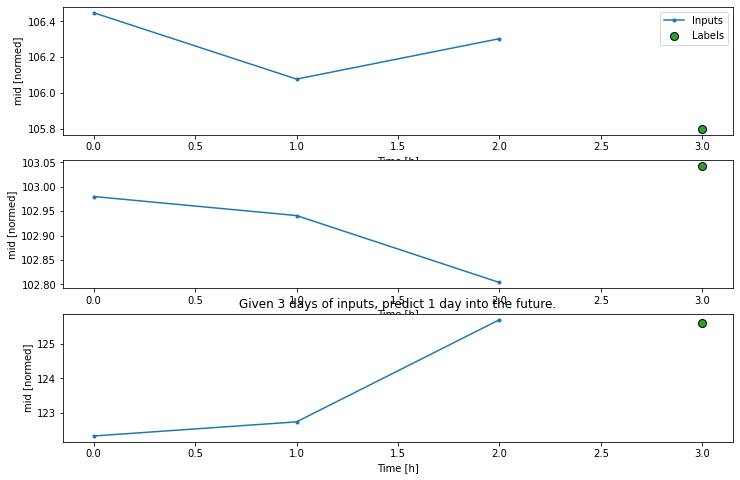

In [45]:
conv_window.plot()
plt.title("Given 3 days of inputs, predict 1 day into the future.")

In [46]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [47]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [48]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/20
10/10 [==============================] - 1s 36ms/step - loss: 6225.2373 - mean_absolute_error: 77.6413 - val_loss: 4383.3628 - val_mean_absolute_error: 65.8588
Epoch 2/20
10/10 [==============================] - 0s 20ms/step - loss: 2701.7253 - mean_absolute_error: 50.9307 - val_loss: 1448.8176 - val_mean_absolute_error: 37.5183
Epoch 3/20
10/10 [==============================] - 0s 21ms/step - loss: 702.3352 - mean_absolute_error: 25.2988 - val_loss: 180.6138 - val_mean_absolute_error: 11.8642
Epoch 4/20
10/10 [==============================] - 0s 21ms/step - loss: 45.0339 - mean_absolute_error: 5.0741 - val_loss: 75.1010 - val_mean_absolute_error: 7.4574
Epoch 5/20
10/10 [==============================] - 0s 19ms/step - loss: 63.3943 - mean_absolute_error: 7.1553 - val_loss: 118.9811 - val_mean_absolute_error: 9.8135
Epoch 6/20
10/10 [==============================] - 0s 20ms/step - loss: 45.9934 - mean_absolute_error: 5.9356 - val_loss: 53.9338 - val_mean_absolute_error: 

In [50]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 1)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [51]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = window.WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    df_train = df_train,
    df_val = df_val,
    df_test = df_test,
    label_columns=['mid'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['mid']

In [52]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 1)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


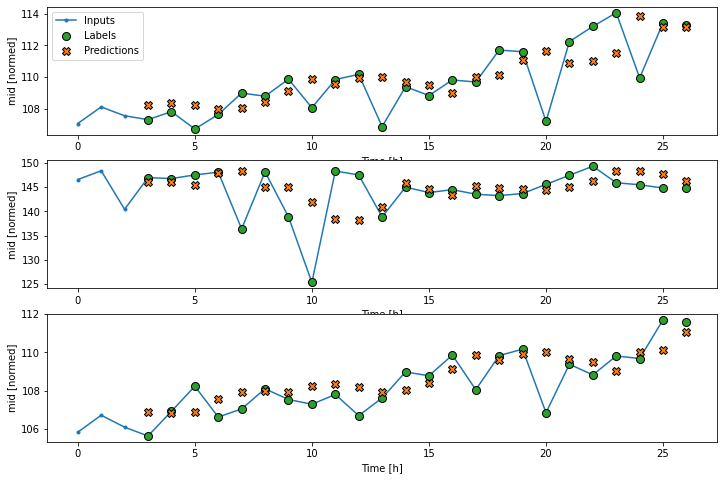

In [53]:
wide_conv_window.plot(conv_model)

In [54]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [60]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [61]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
9/9 [==============================] - 2s 81ms/step - loss: 13058.9453 - mean_absolute_error: 113.0915 - val_loss: 14493.4902 - val_mean_absolute_error: 120.1352
Epoch 2/20
9/9 [==============================] - 0s 23ms/step - loss: 13010.7100 - mean_absolute_error: 112.8770 - val_loss: 14443.3926 - val_mean_absolute_error: 119.9265
Epoch 3/20
9/9 [==============================] - 0s 21ms/step - loss: 12963.9795 - mean_absolute_error: 112.6690 - val_loss: 14394.0527 - val_mean_absolute_error: 119.7206
Epoch 4/20
9/9 [==============================] - 0s 23ms/step - loss: 12917.5859 - mean_absolute_error: 112.4634 - val_loss: 14345.1211 - val_mean_absolute_error: 119.5160
Epoch 5/20
9/9 [==============================] - 0s 23ms/step - loss: 12871.4707 - mean_absolute_error: 112.2589 - val_loss: 14296.3848 - val_mean_absolute_error: 119.3119
Epoch 6/20
9/9 [==============================] - 0s 23ms/step - loss: 12825.6641 - mean_absolute_error: 112.0545 - val_loss: 14247.670

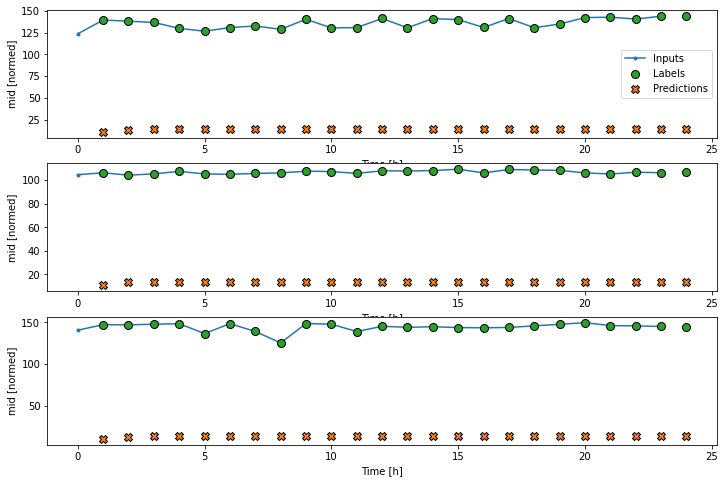

In [62]:
wide_window.plot(lstm_model)

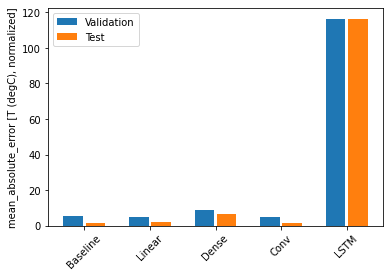

In [63]:
import numpy as np
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()